In [1]:
from tensorflow_docs.vis import embed
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import DataCreation as Dc
import FeatureExtract as Fe
import ModelBuild as Mb
import numpy as np
import cv2
import os
import logging
import secrets
import imageio
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
Data = Dc.collectData('Words', None, None)

In [3]:
Data.frameVideo()

In [2]:
extract_data = Fe.FeatureExtraction()

In [3]:
extract_data.extract_coordinates('Words', 60)

In [4]:
landmark, classes = extract_data.concatenate_data_pts('Words', 60)

In [5]:
np.save(os.path.join(os.getcwd(), 'WordClasses'), classes)
np.save(os.path.join(os.getcwd(), 'WordLandmarks'), landmark)

In [2]:
X = np.load('vidLandmarks.npy')
Y = np.load('vidClasses.npy')
Y = to_categorical(Y).astype(int)

In [3]:
print(X.shape)
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=0.025)
print(XTrain.shape, YTrain.shape)

(2400, 60, 258)
(2340, 60, 258) (2340, 16)


In [4]:
Transformer_model = Mb.ModelBuild(X.shape[1], X.shape[2], 7, 3, 16, 50)
model = Transformer_model.fitTransform('Words', XTrain, YTrain)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None)]      0         
_________________________________________________________________
frame_position_embedding (Po (None, None, 258)         15480     
_________________________________________________________________
transformer_encode_layer (Tr (None, None, 258)         806257    
_________________________________________________________________
global_max_pooling1d (Global (None, 258)               0         
_________________________________________________________________
dropout (Dropout)            (None, 258)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                4144      
Total params: 825,881
Trainable params: 825,881
Non-trainable params: 0
_______________________________________________________

Epoch 25/50
49/49 [==============================] - 2s 34ms/step - loss: 0.1751 - categorical_accuracy: 0.9381 - val_loss: 0.2001 - val_categorical_accuracy: 0.9379

Epoch 00025: val_loss did not improve from 0.16585
Epoch 26/50
49/49 [==============================] - 2s 33ms/step - loss: 0.2023 - categorical_accuracy: 0.9311 - val_loss: 0.2178 - val_categorical_accuracy: 0.9366

Epoch 00026: val_loss did not improve from 0.16585
Epoch 27/50
49/49 [==============================] - 2s 34ms/step - loss: 0.1726 - categorical_accuracy: 0.9432 - val_loss: 0.1992 - val_categorical_accuracy: 0.9392

Epoch 00027: val_loss did not improve from 0.16585
Epoch 28/50
49/49 [==============================] - 2s 35ms/step - loss: 0.1687 - categorical_accuracy: 0.9400 - val_loss: 0.1197 - val_categorical_accuracy: 0.9728

Epoch 00028: val_loss improved from 0.16585 to 0.11972, saving model to D:\downloads\UOW\CSIT998 project\project\ASL\projectrefactoring\word_weights.hdf5
Epoch 29/50
49/49 [======

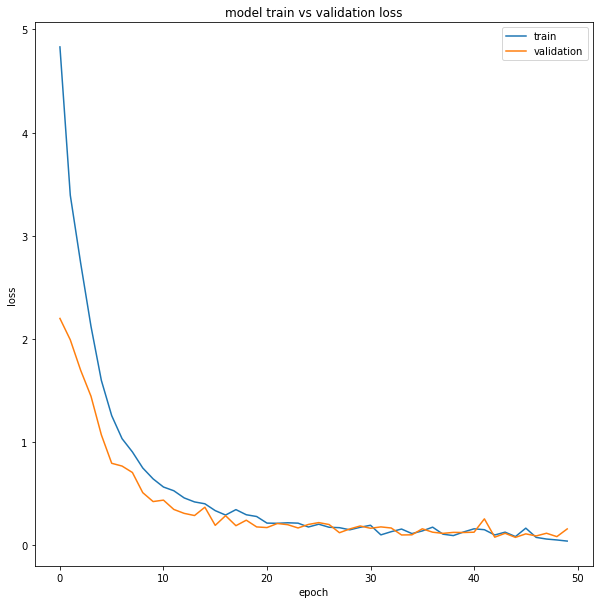

2/2 [==============================] - 0s 13ms/step - loss: 0.0384 - categorical_accuracy: 0.9833
Test accuracy: 98.33%


In [5]:
Transformer_model.stats(XTest, YTest)

In [7]:
Transformer_model = Mb.ModelBuild(X.shape[1], X.shape[2], 7, 3, 16, 50)
model = Transformer_model.constructModel()
model.load_weights(os.path.join(os.getcwd(),'word_weights.hdf5'))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None)]      0         
_________________________________________________________________
frame_position_embedding (Po (None, None, 258)         15480     
_________________________________________________________________
transformer_encode_layer (Tr (None, None, 258)         806257    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 258)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 258)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                4144      
Total params: 825,881
Trainable params: 825,881
Non-trainable params: 0
_____________________________________________________

In [8]:
res = model.predict(XTest)

In [9]:
ytrue = np.argmax(YTest, axis=1).tolist()
yhat = np.argmax(res, axis=1).tolist()
iter_folder = os.listdir(os.path.join(os.getcwd(), 'Data', 'Words'))
actions = np.array(os.listdir(os.path.join(os.getcwd(), 'Data', 'Words', iter_folder[0])))

In [10]:
print(actions)

['Black' 'Cappuccino' 'Chocolate' 'Coffee' 'Flat' 'Hot' 'Large' 'Latte'
 'Long' 'No' 'None' 'Regular' 'Short' 'Small' 'White' 'Yes']


In [11]:
cm = confusion_matrix(ytrue, yhat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=actions)

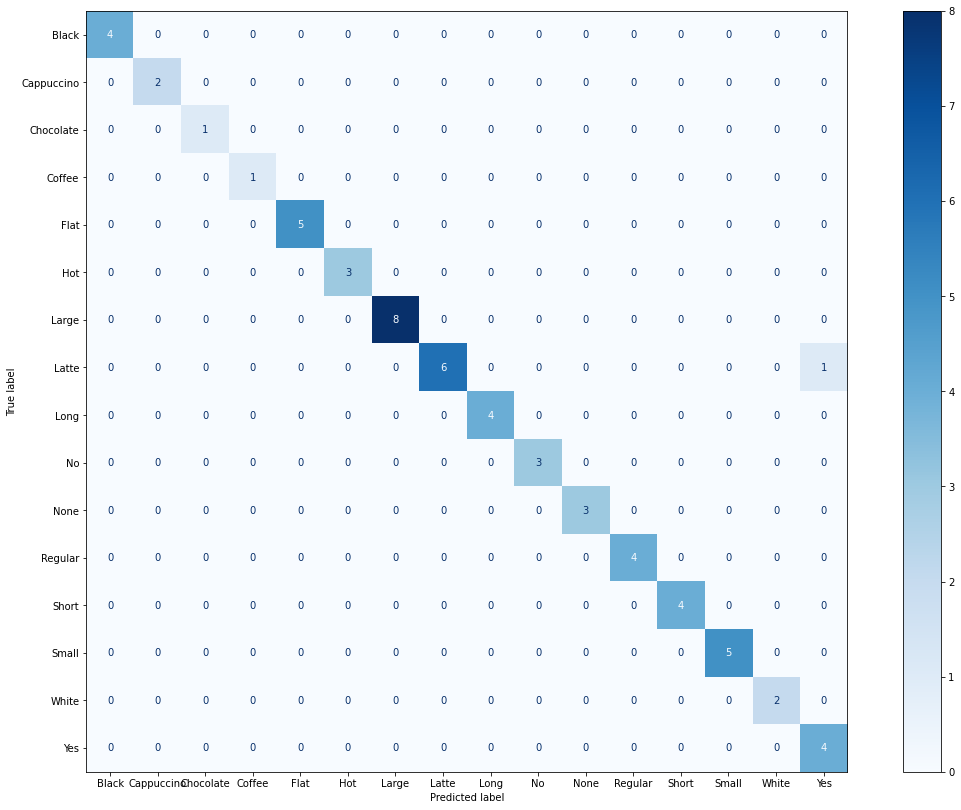

In [12]:
plt.rcParams["figure.figsize"] = (20,14)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [13]:
feature = Fe.FeatureExtraction()

In [14]:
def vidfeatureextract(random_test):
    sequence =[]
    cap = cv2.VideoCapture(os.path.join(os.getcwd(),'test', random_test))
    with Fe.mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while(cap.isOpened()):
            ret, frame = cap.read()
    #         print(ret)
            if ret is True:
                image, results = feature.mp_detect(frame, holistic)
                # draw_styled_landmarks(image,results)
                keypoints = feature.get_coordinates()
                sequence.append(keypoints)
                if cv2.waitKey(1) == ord('q'):
                    break
            else:
                break
    cap.release()
    cv2.destroyAllWindows()
    sequence = sequence[-60:]
    return sequence

def to_gif(images):
    reader = imageio.get_reader(os.path.join(os.getcwd(),'test', random_test))
    images =[]
    for frames in reader:
        images.append(frames)
    imageio.mimsave("animation.gif", images, fps=15)
    return embed.embed_file("animation.gif")

def predictPercentage(random_test):
    res = model.predict(np.expand_dims(vidfeatureextract(random_test), axis=0))[0]
#     print(actions[np.argsort(res)][0], ' : ', res[0], 'Actual video : ', random_test)
    counter = 0
    for i in np.argsort(res)[::-1]:
        if counter == 0:
            print(f"  {actions[i]}: {res[i] * 100:5.2f}% : {random_test}")
            counter += 1
        

        


In [15]:
for items in os.listdir(os.path.join(os.getcwd(), 'test')):
#     print(items)
    predictPercentage(items)
    print("-------------------")
#     to_gif(random_test)

  Black: 98.68% : SusBlack-vid7.avi
-------------------
  Cappuccino: 99.98% : SusCappuccino-vid18.avi
-------------------
  Latte: 87.65% : SusLatte-vid27.avi
-------------------
  No: 91.80% : SusNo-vid8.avi
-------------------
  White: 93.12% : SusWhite-vid5.avi
-------------------
  Chocolate: 99.68% : testChocolate-vid.avi
-------------------
  Coffee: 98.79% : testCoffee-vid.avi
-------------------
  Flat: 99.99% : testFlat-vid.avi
-------------------
  Hot: 99.99% : testHot-vid.avi
-------------------
  Large: 99.47% : testLarge-vid.avi
-------------------
  Long: 99.88% : testLong-vid.avi
-------------------
  Regular: 99.99% : testRegular-vid.avi
-------------------
  Short: 99.98% : testShort-vid.avi
-------------------
  Small: 64.32% : testSmall-vid.avi
-------------------
